In [3]:
import numpy as np
import pandas as pd
import collections

from IPython import display
from matplotlib import pyplot as plt
import sklearn
from sklearn import preprocessing

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

from urllib.request import urlretrieve
import zipfile

# Load the data and select features

We will use a smaller version of the [movielens](https://grouplens.org/datasets/movielens/) dataset. It contains data of movies rated by users, demographic data from these users and some information about the movies like release date and genre.

Demographic data will not be considered, we will only use the users ratings. 

In [4]:
#Download the dataset
print('Downloading Dataset...')
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info').decode('utf-8'))

Done. Dataset contains:
943 users
1682 items
100000 ratings



In [5]:
#Demographic data about users
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

#User rated movies
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

#Movies info
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

In [6]:
#ids start at one, shift to zero
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [7]:
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [47]:
#select features
df = movielens[['user_id', 'movie_id', 'rating']]
df.head(5)

,user_id,movie_id,rating
0,195,241,3.0
1,195,256,2.0
2,195,110,4.0
3,195,24,4.0
4,195,381,4.0


# Build the model

We will build a collaborative filtering matrix decomposition model using Tensorflow. 

Since our data is represented by a sparse matrix, we can use tf.SparseTensor as a more efficient representation by only storing the non-sparse part of the data.

We will also regularize this model to optimize its efficiency. 

Our loss function will also take advantage from the sparsity of the problem.

In [18]:
def split_dataframe(df, holdout_fraction=0.1):
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

def build_sparse_tensor(_df):
    indices = _df[['user_id', 'movie_id']].values
    values = _df['rating'].values
    return tf.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=[df['user_id'].unique().shape[0], df['movie_id'].unique().shape[0]])

def sparse_mean_square_error(sparse_tensor, user_embeddings, movie_embeddings):
    predictions = tf.gather_nd(
        tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
        sparse_tensor.indices)
    loss = tf.losses.mean_squared_error(sparse_tensor.values, predictions)
    return loss

class CFModel(object):
    """Simple class that represents a collaborative filtering model"""
    def __init__(self, embedding_vars, loss, metrics=None):
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None

    @property
    def embeddings(self):
        return self._embeddings

    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
        
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
                tf.variables_initializer(opt.variables()),
                tf.local_variables_initializer())
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

            # Train and append results.
            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(
                        ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                        end='')
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)

                for k, v in self._embedding_vars.items():
                    self._embeddings[k] = v.eval()

            if plot_results:
                # Plot the metrics.
                num_subplots = len(metrics)+1
                fig = plt.figure()
                fig.set_size_inches(num_subplots*10, 8)
                for i, metric_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i+1)
                    for k, v in metric_vals.items():
                        ax.plot(iterations, v, label=k)
                    ax.set_xlim([1, num_iterations])
                    ax.legend()
            return results
        
def gravity(U, V):
    """Creates a gravity loss given two embedding matrices."""
    return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
        tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    _df, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
    
    # Split the ratings DataFrame into train and test.
    train_df, test_df = split_dataframe(_df)
    # SparseTensor representation of the train and test datasets.
    A_train = build_sparse_tensor(train_df)
    A_test = build_sparse_tensor(test_df)
    U = tf.Variable(tf.random_normal(
        [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal(
        [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

    error_train = sparse_mean_square_error(A_train, U, V)
    error_test = sparse_mean_square_error(A_test, U, V)
    gravity_loss = gravity_coeff * gravity(U, V)
    regularization_loss = regularization_coeff * (
        tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
    total_loss = error_train + regularization_loss + gravity_loss
    losses = {
        'train_error_observed': error_train,
        'test_error_observed': error_test,
    }
    loss_components = {
        'observed_loss': error_train,
        'regularization_loss': regularization_loss,
        'gravity_loss': gravity_loss,
    }
    embeddings = {
        "user": U,
        "movie": V
    }

    return CFModel(embeddings, total_loss, [losses, loss_components])

 iteration 2000: train_error_observed=0.998269, test_error_observed=2.457621, observed_loss=0.998269, regularization_loss=0.853033, gravity_loss=1.3175334

[{'train_error_observed': 0.9982689, 'test_error_observed': 2.457621},
 {'observed_loss': 0.9982689,
  'regularization_loss': 0.8530325,
  'gravity_loss': 1.3175325}]

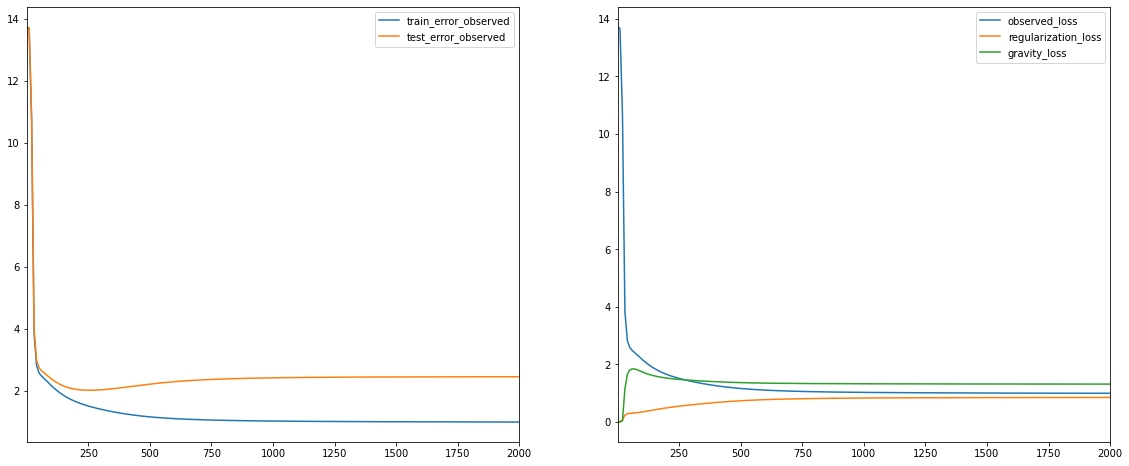

In [19]:
model = build_regularized_model(
    df, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
model.train(num_iterations=2000, learning_rate=20.)

# Results

Now we can check each movie neighbors based on a metric and also recommend movies to some user. Let's check a user's history and see if the recommendations make any sense.

In [28]:
DOT = 'dot'
COS = 'cosine'

def compute_scores(user_embedding, movie_embeddings, measure=COS):

    u = user_embedding
    V = movie_embeddings
    if measure == COS:
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        u = u / np.linalg.norm(u)
    scores = u.dot(V.T)
    return scores

def recommendations(model, user_id, measure=COS, exclude_rated=True, k=6):
    scores = compute_scores(
        model.embeddings["user"][user_id], model.embeddings["movie"], measure)
    score_key = measure + ' score'
    _df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
    })
    if exclude_rated:
        #remove items already in use
        _list = df[df['user_id'] == user_id]["movie_id"]
        _df = _df[_df.movie_id.apply(lambda movie_id: movie_id not in _list)]  
    
    display.display(_df.sort_values([score_key], ascending=False).head(k))
    
def neighbors(model, movie_id, measure=COS, k=6):
    
    scores = compute_scores(
        model.embeddings["movie"][movie_id], model.embeddings["movie"],
        measure)
    score_key = measure + ' score'
    _df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
    })
    
    display.display(_df.sort_values([score_key], ascending=False).head(k))

In [51]:
#sample a movie id and check its neighbors
neighbors(model, int(df.sample(1)['movie_id'].to_list()[0]), measure=COS, k=6)

,cosine score,movie_id,titles
167,1.000000,167,Monty Python and the Holy Grail (1974)
153,0.863389,153,Monty Python's Life of Brian (1979)
172,0.838815,172,"Princess Bride, The (1987)"
207,0.797019,207,Young Frankenstein (1974)
208,0.784966,208,This Is Spinal Tap (1984)
473,0.736949,473,Dr. Strangelove or: How I Learned to Stop Worr...


In [49]:
#get recommendations for a user
recommendations(model, 4, measure=COS, k=5)

,cosine score,movie_id,titles
435,0.662958,435,"American Werewolf in London, An (1981)"
385,0.662173,385,Addams Family Values (1993)
389,0.651974,389,Fear of a Black Hat (1993)
445,0.641149,445,Burnt Offerings (1976)
395,0.615418,395,Serial Mom (1994)


In [32]:
#user's history
movielens[movielens['user_id'] == '4']

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,...,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
42382,4,376,1.0,878844615,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,...,0,0,0,0,0,1994,33,F,other,15213
42383,4,450,1.0,875636571,Grease (1978),01-Jan-1978,NaN,http://us.imdb.com/M/title-exact?Grease%20(1978),0,0,...,1,0,0,0,0,1978,33,F,other,15213
42384,4,256,5.0,875635239,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,...,0,1,0,0,0,1997,33,F,other,15213
42385,4,221,4.0,875635174,Star Trek: First Contact (1996),22-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Star%20Trek:%...,0,1,...,0,1,0,0,0,1996,33,F,other,15213
42386,4,39,4.0,879198109,"To Wong Foo, Thanks for Everything! Julie Newm...",01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?To%20Wong%20F...,0,0,...,0,0,0,0,0,1995,33,F,other,15213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42552,4,387,2.0,879198898,Beverly Hills Cop III (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Beverly%20Hil...,0,1,...,0,0,0,0,0,1994,33,F,other,15213
42553,4,441,1.0,879198898,"Amityville Curse, The (1990)",01-Jan-1990,NaN,http://us.imdb.com/M/title-exact?Amityville%20...,0,0,...,0,0,0,0,0,1990,33,F,other,15213
42554,4,399,1.0,878844630,"Little Rascals, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Little%20Rasc...,0,0,...,0,0,0,0,0,1994,33,F,other,15213
42555,4,437,1.0,878844423,Amityville 3-D (1983),01-Jan-1983,NaN,http://us.imdb.com/M/title-exact?Amityville%20...,0,0,...,0,0,0,0,0,1983,33,F,other,15213
